# Uniform Design

**For this design, we aim to spread sample sites uniformly within the range of the metric.**

In this notebook we will first show the concept of the design using a single metric, we will then show how it can be run for multiple metric designs. Example files can be used to test the code. These consist of:

 - HabitatMap.tif
 - DistanceToEdgeLog2.tif
 - FragmentAreaLog10.tif
 - InvalidAreasMask.tif
 
**NOTE: Cells must be run sequentially, to ensure all variables are loaded at each stage.**

### Import required libraries

In [239]:
import os
from osgeo import gdal, osr
import numpy as np
from random import randint
from scipy import ndimage
from copy import copy
import time
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

class map_metrics:
    
    def __init__(self, map_path, mask_path, nbins):
        
        self.map_path = map_path
        self.mask_path = mask_path
        self.nbins = nbins
        
        self.map_array = self.get_array(self.map_path)
        self.mask_array = self.get_array(self.mask_path)
        
        self.masked_map = np.ma.masked_array(self.map_array, mask=1-self.mask_array)
      
    def get_array(self, file_path):
        
        raster_raw = gdal.Open(file_path)
        raster = raster_raw.ReadAsArray()
        return raster
    
    def mask_map(self):
        return np.ma.masked_array(self.map_array, mask=1-self.mask_array)
    
    def get_proj_info(self):
        
        file_raw = gdal.Open(self.map_path)
        prj_info = file_raw.GetProjection()
        GeoT = file_raw.GetGeoTransform()
        res = GeoT[1]
        nbins = len(np.unique(self.map_array))
        
        print('\nNumber of categories in map: {}'.format(nbins))
        print('Pixel resolution (m): {}'.format(res))
        print('GeoT info: {}'.format(GeoT))

        return nbins, res, GeoT, prj_info
    
    def plot_map(self):
        
        plt.figure(figsize=(6, 6))
        plt.imshow(self.get_map())
        plt.show()
        
    def plot_histogram(self):
        
        plt.figure(figsize=(7, 5))
        plt.hist(self.masked_map.compressed(), bins=self.nbins)
        plt.xlabel('Metric 1 values')
        plt.ylabel('Number of pixels in range')
        plt.show()
        
    def discretize_metric(self):
        imheight, imwidth = self.map_array.shape
        # Break range of masked metric values into 'nbin' intervals
        hist, breaks= np.histogram(self.masked_map.compressed(), bins = self.nbins)
        # Make empty arrays to store results
        ##############ids = range(nbins) ##################
        ids = np.linspace(0, self.nbins-1, self.nbins).astype(int)
        ones = np.ones((imheight, imwidth))
        metric_bin = np.zeros((imheight, imwidth))
        # Loop through ID's and convert all values in each bin to corresponding id
        for ID in ids:
            # Closed on the lower bound, open on the upper
            lower_lim=np.where(ones, self.masked_map>=breaks[ID], 0)
            upper_lim=np.where(ones, self.masked_map<breaks[ID+1], 0)
            # Make the last interval closed at the upper bound
            if ID == self.nbins-1:
                upper_lim = np.where(ones, self.masked_map<=breaks[ID+1], 0)
            metric_bin += lower_lim*upper_lim*ID
        return metric_bin, ids, breaks, hist
    
    def plot_discrete_metric(self):
        discrete_metric, _, _, _ = self.discretize_metric()
        
        plt.imshow(discrete_metric, cmap=plt.cm.get_cmap('jet', self.nbins))
        plt.title('Binned Metric Map')
        cbar = plt.colorbar()
        cbar.set_ticks(metric1_id)
        cbar.set_ticklabels(metric1_id)
        plt.show()

        
def extract_rasters(raster_path):
    '''
    Function which reads a geotiff file as a numpy array
    '''
    raster_raw = gdal.Open(raster_path)
    raster = raster_raw.ReadAsArray()
    return raster

def get_file_info(file_path):
    '''
    Function which extracts a geotiff file as numpy array, and saves geographic projection information
    input: 
        file_path: (str) Path to the file
    output: 
        file_map: (np.array) The extracted map
        nbins: (int) The number of categories in the map
        res: (float) Resolution of the map in meters
        GeoT: The geographic transform used to project the map
        auth_code: The authority code matching the projection
    '''
    file_raw = gdal.Open(file_path)
    prj_info = file_raw.GetProjection()
    GeoT = file_raw.GetGeoTransform(); res = GeoT[1]
    file_map = file_raw.ReadAsArray()
    nbins = len(np.unique(file_map))
    return file_map, nbins, res, GeoT, prj_info

In [243]:
metric1 = map_metrics(hab_path, mask_path, bins1)

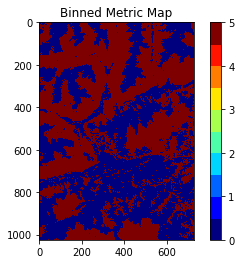

In [244]:
metric1.plot_discrete_metric()

# Single metric example

## User Inputs
**NOTE: Sections where users can enter their own values or file names are highlighted with #'s.**

Specify a unique name for the project as `save_folder`. A folder with your chosen name will be created in the `results` folder, and all outputs for the design will be saved there. E.g:

In [3]:
###################################
save_folder = 'Uniform_Design_Demo'
###################################

In [4]:
directory = 'results/{}'.format(save_folder)
if not os.path.exists(directory):
    os.makedirs(directory)

# Create unique time stamp to add to file names (to avoid overwriting)
ts = time.gmtime()
ts = time.strftime("%Y_%m_%d_%H%M%S", ts)

print('Results will be saved in the folder {}'.format(directory))
print('Files will start with the time stamp {}'.format(ts))

Results will be saved in the folder results/Uniform_Design_Demo
Files will start with the time stamp 2019_12_03_213845


#### Habitat category map
Enter name of the habitat/non-habitat map used to derive your metrics. This should be in GeoTiff format. E.g:

In [5]:
#############################
hab_path = 'raw/HabitatMap.tif'
#############################

**Load** the map and extract the projection information...

In [6]:
print('Loading {} ...'.format(hab_path))

habmap, hab_bins, res, GeoT, prj_info = get_file_info(hab_path)

print('\nNumber of habitat categories in map: {}'.format(hab_bins))
print('Pixel resolution (m): {}'.format(res))
print('GeoT info: {}'.format(GeoT))

Loading raw/HabitatMap.tif ...

Number of habitat categories in map: 2
Pixel resolution (m): 30.0
GeoT info: (604343.5084861958, 30.0, 0.0, 5302852.190465175, 0.0, -30.0)


Now **plot** the map. This should be categorical (e.g habitat and non-habitat)...

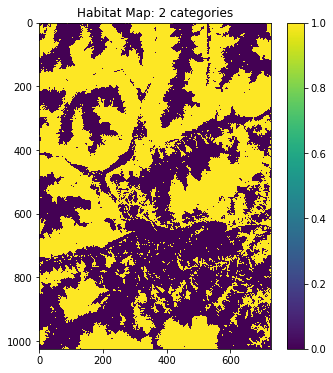

In [7]:
plt.figure(figsize=(6, 6))
plt.imshow(habmap)
plt.title('Habitat Map: {} categories'.format(len(np.unique(habmap))))
cbar = plt.colorbar()
plt.show()

#### Invalid areas mask
Enter path to invalid areas mask (if there are any you wish to exclude). This can be used to mask out things like inaccessible areas, high altitudes, or habitat categories which you do not wish to sample in. 

**In this example we will mask out an entire habitat category, so we can see how the method works in the simplest single habitat, single metric case**

In [8]:
######################################
mask_path = 'raw/InvalidAreasMask.tif'
######################################

Extract the mask...

In [156]:
mask = extract_rasters(mask_path)

Now **plot** the mask...

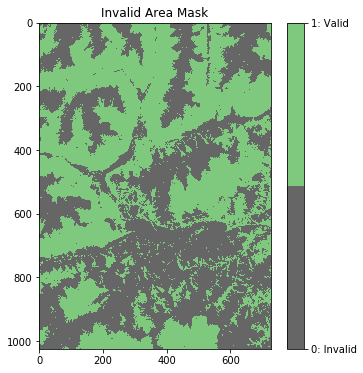

In [157]:
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('Invalid Area Mask')
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.show()

#### Fragmentation metric map
We will now enter our habitat fragmentation maps. In this **first example we will use a single map** - showing distance to the nearest habitat edge at log2 scale. We will see how the uniform design places sites evenly within the range of the chosen metric.

The number of metrics ```n_metrics``` for this example is one. So:

In [11]:
###############
n_metrics = 1
###############

Here we enter the name of our metric map, which should be saved as a GeoTiff file. E.g:

In [12]:
#####################################
metric1_path = 'raw/DistanceToEdgeLog2.tif'
#####################################

**Load** the metric...

In [13]:
metric1 = extract_rasters(metric1_path)

And **plot**...

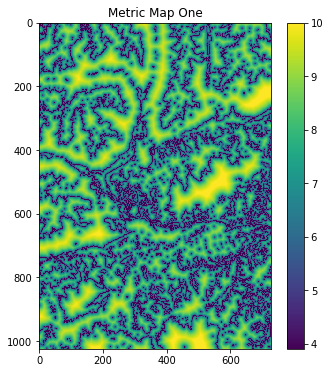

In [14]:
plt.figure(figsize=(6, 6))
plt.imshow(metric1)
plt.title('Metric Map One')
cbar = plt.colorbar()
plt.show()

We want to **mask** innaccessible areas of the metric, so we apply the invalid areas mask we loaded earlier

In [15]:
metric1_mask = np.ma.masked_array(metric1, mask=1-mask)

Now **plot** the masked metric. If you chose not to enter the mask there should be no change...

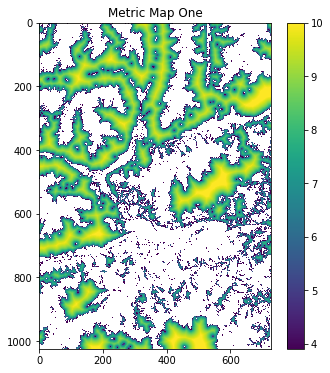

In [16]:
plt.figure(figsize=(6, 6))
plt.imshow(metric1_mask)
plt.title('Metric Map One')
cbar = plt.colorbar()
plt.show()

This map represents the distance to nearest edge value for all pixels within the unmasked landscape. We want to assess the distribution of these metric values. First we **set the number of bins**. This should be **an integer value**, and specifies how many equal intervals the range of the metric should be broken into. E.g:

In [17]:
##########
bins1 = 10
##########

Now plot a histogram showing the distribution of pixel values in each bin.

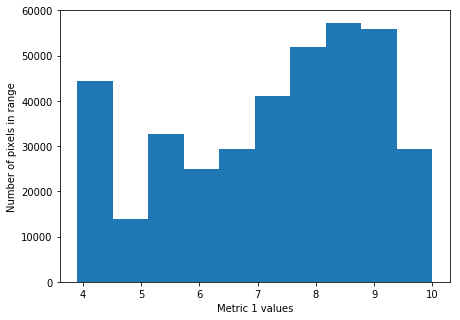

In [18]:
plt.figure(figsize=(7, 5))
plt.hist(metric1_mask.compressed(), bins=bins1)
plt.xlabel('Metric 1 values')
plt.ylabel('Number of pixels in range')
plt.show()

As we can see from the histogram, some metric values are represented by larger areas of the landscape. However if we wish to study a species' response to distance to edge, we should place our sample sites uniformly within the range of the histogram. Try altering the number of bins and see how the distribution changes. 

### Discretize the metric
We now convert the contiuous metric to a categorical metric, where each pixel is labelled according to the bin it falls in in our histogram

In [97]:
def discretize_metric(metric, mask, nbins):
    """Convert continuous metrics into discrete, using the specified number of bins"""
    imheight, imwidth = metric.shape
    # Mask out invalid areas of metric
    metric_mask = np.ma.masked_array(metric, mask=mask)
    # Break range of masked metric values into 'nbin' intervals
    hist, breaks= np.histogram(metric_mask.compressed(), bins = nbins)
    # Make empty arrays to store results
    ##############ids = range(nbins) ##################
    ids = np.linspace(0, nbins-1, nbins).astype(int)
    ones = np.ones((imheight, imwidth))
    metric_bin = np.zeros((imheight, imwidth))
    # Loop through ID's and convert all values in each bin to corresponding id
    for ID in ids:
        # Closed on the lower bound, open on the upper
        lower_lim=np.where(ones, metric_mask>=breaks[ID], 0)
        upper_lim=np.where(ones, metric_mask<breaks[ID+1], 0)
        # Make the last interval closed at the upper bound
        if ID == nbins-1:
            upper_lim = np.where(ones, metric_mask<=breaks[ID+1], 0)
        metric_bin += lower_lim*upper_lim*ID
    return metric_bin, ids, breaks, hist

Create the binned metric map, record the ids and break points...

In [98]:
metric1_binned, metric1_id, metric1_breaks, id_counts = discretize_metric(metric1, 1-mask, bins1)
metric1_binned_mask = np.ma.masked_array(metric1_binned, mask=1-mask)

**Plot** the discrete version of the metric map...

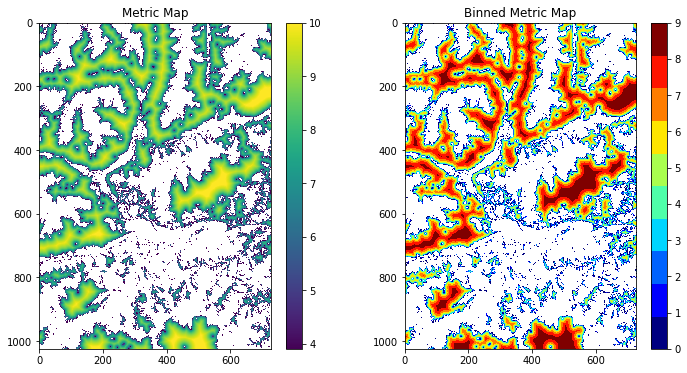

In [62]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(metric1_mask)
plt.title('Metric Map')
plt.colorbar()

plt.subplot(122)
plt.imshow(metric1_binned_mask, cmap=plt.cm.get_cmap('jet', bins1))
plt.title('Binned Metric Map')
cbar = plt.colorbar()
cbar.set_ticks(metric1_id)
cbar.set_ticklabels(metric1_id)

plt.show()

#### Number of sample sites
Finally, enter an integer number of sample sites (```nsp```). E.g

In [22]:
########
nsp = 80
########

In [158]:
combo_df = pd.DataFrame()
combo_df['ID'] = metric1_id
combo_df['n_pixels'] = id_counts

We check the number of pixels in each ID. If there are any zero values we remove them from the list

In [159]:
combo_df

,ID,n_pixels
0,0,44509
1,1,13972
2,2,32779
3,3,25032
4,4,29361
5,5,40991
6,6,51984
7,7,57236
8,8,55933
9,9,29418


We wish to place an equal number of sites in each bin. Calculate this optimum number based on the user input number of sample sites...

In [106]:
def find_opt(combo_df, nsp):
    ID_df = combo_df[combo_df.n_pixels != 0]  # remove empty bins to create ID dataframe
    s_opt = np.float(nsp) / len(ID_df)  # optimum sample sites in each ID
    ID_df = ID_df[ID_df.n_pixels >= 10 * np.ceil(s_opt)]  # remove IDs with too few pixels
    s_opt = np.float(nsp) / len(ID_df)
    return s_opt

In [107]:
s_opt

8.0

In [87]:
#combo_df = pd.DataFrame(metric1_id.T)
imheight, imwidth = metric1_binned_mask.shape
#combo_num = len(combo_df)
all_layers = np.zeros((len(metric1_id), imheight, imwidth))
for i in metric1_id:
    im_layer = np.where(metric1_binned_mask == i, 1, 0)
    all_layers[i, :, :] = im_layer
#     plt.imshow(im_layer)
#     plt.title('{} valid pixels in ID {}'.format(np.sum(im_layer), i))
#     plt.axis('off')
#     plt.colorbar()
#     plt.show()
    

In [ ]:
def generate_all_layers(binned_metrics, n_metrics, mask_inv, combo_df, nvars, nsp):
    """Create single combined ID array and calculate the optimum number of sample sites in each ID """
    imheight, imwidth = mask_inv.shape
    combo_num = len(combo_df)
    # create 3d array to store ID combo layers in
    all_layers = np.zeros((combo_num, imheight, imwidth))
    counts = []
    # Iterate through all unique ID combinations
    for i in range(combo_num):
        im_layer = np.ones((imheight, imwidth))
        for j in range(n_metrics):
            # Convert selected ID to binary for each metric, and multiply together to see where
            # combinations are in the landscape image
            im_layer = np.where(binned_metrics[j] == combo_df.iloc[i][j], 1, 0) * im_layer
        # Make sure invalid areas are set as zero
        layer_mask = im_layer * mask_inv
        counts.append(np.sum(layer_mask))  # Store the number of pixels in each unique combo layer
        all_layers[i, :, :] = layer_mask  # Save combo Id layer in 3d array
    combo_df['Counts'] = counts
    ID_df = combo_df[combo_df.Counts != 0]  # remove empty bins to create ID dataframe
    s_opt = np.float(nsp) / len(ID_df)  # optimum sample sites in each ID
    ID_df = ID_df[ID_df.Counts >= 10 * np.ceil(s_opt)]  # remove IDs with too few pixels
    s_opt = np.float(nsp) / len(ID_df)
    return all_layers, ID_df, s_opt

In [68]:
combo_df = pd.DataFrame(metric1_id.T)

In [70]:
combo_df

,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


### Combine metrics for processing

We will now extend this analysis to look at combinations between multiple metrics

In [329]:
def build_df(bin_ids):
    """Create a dataframe of all combinations of IDs"""
    # Create array of all combinations
    id_mesh = np.meshgrid(*bin_ids)
    # Convert to dataframe, each row represents a unique combination of the ID's
    combo_df = pd.DataFrame([ids.flatten() for ids in id_mesh]).T
    return combo_df


def bin_metrics(input_metrics, mask, n_metrics, nbins):
    """Bin all input metric arrays into discrete ID arrays, and create a dataframe of all the
    unique combinations of these IDs"""
    binned_metrics = []
    bin_ids = []
    bin_breaks = []
    # Generate a binned version of all input metric arrays
    for i in range(n_metrics):
        metric_bin, ids, breaks = discretize_metric(input_metrics[i + 1], mask, nbins[i + 1])
        binned_metrics.append(metric_bin)  # Save all new (discretized) metric arrays
        bin_ids.append(ids)  # Save the list of all IDs present for each array
        bin_breaks.append(breaks)  # Save the bin breaks for each metric
    # Generate dataframe of all combinations of IDs between the input metric arrays
    combo_df = build_df(bin_ids)
    return binned_metrics, combo_df, bin_breaks

In [330]:
immetrics = [habmap, metric1]
nbins = [hab_bins, bins1]

In [331]:
binned_metrics, combo_df, bin_breaks = bin_metrics(immetrics, mask, n_metrics, nbins)

In [ ]:
def generate_layers(binned_metric, n_metrics, mask, combo_df, nvars, nsp):
    imheight, imwidth = binned_metric.shape

In [332]:
def generate_all_layers(binned_metrics, n_metrics, mask_inv, combo_df, nvars, nsp):
    """Create single combined ID array and calculate the optimum number of sample sites in each ID """
    imheight, imwidth = mask_inv.shape
    combo_num = len(combo_df)
    # create 3d array to store ID combo layers in
    all_layers = np.zeros((combo_num, imheight, imwidth))
    counts = []
    # Iterate through all unique ID combinations
    for i in range(combo_num):
        im_layer = np.ones((imheight, imwidth))
        for j in range(n_metrics):
            # Convert selected ID to binary for each metric, and multiply together to see where
            # combinations are in the landscape image
            im_layer = np.where(binned_metrics[j] == combo_df.iloc[i][j], 1, 0) * im_layer
        # Make sure invalid areas are set as zero
        layer_mask = im_layer * mask_inv
        counts.append(np.sum(layer_mask))  # Store the number of pixels in each unique combo layer
        all_layers[i, :, :] = layer_mask  # Save combo Id layer in 3d array
    combo_df['Counts'] = counts
    ID_df = combo_df[combo_df.Counts != 0]  # remove empty bins to create ID dataframe
    s_opt = np.float(nsp) / len(ID_df)  # optimum sample sites in each ID
    ID_df = ID_df[ID_df.Counts >= 10 * np.ceil(s_opt)]  # remove IDs with too few pixels
    s_opt = np.float(nsp) / len(ID_df)
    return all_layers, ID_df, s_opt

In [333]:
nsp = 80

In [334]:
all_layers, ID_df, s_opt = generate_all_layers(binned_metrics, n_metrics, mask, combo_df, n_metrics, nsp)

In [335]:
ID_df

,0,Counts
0,0,44509.0
1,1,13972.0
2,2,32779.0
3,3,25032.0
4,4,29361.0
5,5,40991.0
6,6,51984.0
7,7,57236.0
8,8,55933.0
9,9,29418.0


In [336]:
def generate_ID_im(all_layers, ID_df, nsp, savepath, timestamp):
    imdepth, imheight, imwidth = all_layers.shape
    ID_im = np.zeros((imheight, imwidth))
    store_masks = np.zeros((len(ID_df), imheight, imwidth))
    counter = 0;
    unique_IDs = []
    for k in ID_df.index.values:
        store_masks[counter, :, :] = all_layers[k, :, :]
        ID_im += all_layers[k, :, :] * (counter + 1)
        unique_IDs.append(counter + 1)
        counter += 1
    # Save an ID image for adapted uniform designs
    np.save("{}/{}_Uniform_IDim".format(directory, timestamp), ID_im)
    return store_masks, ID_im, unique_IDs

In [111]:
def generate_ID_im(all_layers, ID_df, nsp):
    imdepth, imheight, imwidth = all_layers.shape
    ID_im = np.zeros((imheight, imwidth))
    store_masks = np.zeros((len(ID_df), imheight, imwidth))
    counter = 0;
    unique_IDs = []
    for k in ID_df.index.values:
        store_masks[counter, :, :] = all_layers[k, :, :]
        ID_im += all_layers[k, :, :] * (counter + 1)
        unique_IDs.append(counter + 1)
        counter += 1
    return store_masks, ID_im, unique_IDs

In [112]:
store_masks, ID_im, unique_IDs = generate_ID_im(all_layers, ID_df, nsp)

In [122]:
def upper_lower_suggest(nsp, ID_df):
    """Calculate upper and lower number of sample sites to meet uniform distribution """
    nsp = float(nsp)
    n_bins = len(ID_df)
    nsp_lower = np.floor(nsp / n_bins) * n_bins
    nsp_upper = np.ceil(nsp / n_bins) * n_bins
    return nsp_lower.astype(int), nsp_upper.astype(int)

In [129]:
nsp%n_bins * n_bins

72

In [123]:
upper_lower_suggest(nsp, ID_df)

(80, 80)

In [137]:
# repeat every element in list s_opt times
id_rep = unique_IDs * int(s_opt)

# if you have extra sites then space them evenly 
# alternative ends of list?
# number of ids % remainder
# Check spacing
# Slice list and append those IDs
# If slice less than one then just select randomly

# Randomly shuffle order

In [340]:
def generate_id_list(unique_IDs, s_opt, nsp, ID_df):
    """Create a list where each unique ID is repeated by s_opt"""
    id_rep = np.repeat(unique_IDs, np.floor(s_opt))
    # If there is a difference in the number of sample sites and the number of elements
    # in id_rep then add extras randomly from the list of IDs, without replacement
    diff = nsp - len(id_rep)
    while diff >= len(unique_IDs):
        id_rep = np.hstack([id_rep, unique_IDs])
        diff = nsp - len(id_rep)
    extra_sites = np.random.choice(unique_IDs, nsp - len(id_rep), replace=False)
    id_list = np.hstack([id_rep, extra_sites])  # Now list of length nsp
    # Randomly permute list
    id_mix = np.random.choice(id_list, nsp, replace=False)
    # If nsp is less than the number of IDs (i.e one or less sample per ID),
    # then create a reduced dataframe
    if len(id_mix) < len(unique_IDs):
        id_mix.sort()
        ID_df = ID_df.iloc[id_mix]
    ID_df['Freq'] = np.unique(id_mix, return_counts=True)[1]
    return id_mix, ID_df

In [341]:
id_mix, ID_df = generate_id_list(unique_IDs, s_opt, nsp, ID_df)

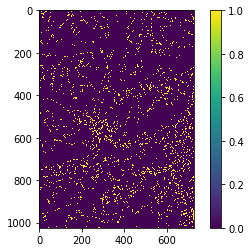

In [149]:
plt.imshow(np.where(ID_im==1, 1, 0))
plt.colorbar()
plt.show()

## Generate uniform design

In [153]:
## replace the store_masks with the ID_im. Create mask in each loop by converting all ID values to one, zeros elsewhere
def generate_uniform_design(id_mix, ID_im):

    imheight, imwidth = ID_im.shape
    dist_im = np.ones((imheight, imwidth))
    sites = np.ones((imheight, imwidth))
    x_vals = []
    y_vals = []
    loop_count = 0
#     nsp = len(id_mix)

    for i in id_mix:
        
        loop_count += 1
        print('Plotting site {}, id number {}'.format(loop_count, i))

        # Select binary map relating to selected ID
        mask_ID = np.where(ID_im==i, 1, 0)
        # Mask out any regions of EDT not in ID
        layer = mask_ID * dist_im

        # Extract coords of pixels with maximum distance value and choose one at random
        dist_mx = list(zip(*np.where(layer == layer.max())))
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]
        
        # Save coordinates
        x_vals = np.append(x_vals, x)
        y_vals = np.append(y_vals, y)

        # Add selected site to sites array as 0 (feature pixel)
        sites[x, y] = 0

        # Compute EDT from all placed sites
        dist_im = ndimage.distance_transform_edt(sites)

#     xy0 = np.hstack([x_vals, y_vals])
    print('Uniform sample design complete!')

    return x_vals, y_vals

In [154]:
x_unif, y_unif = generate_uniform_design(id_rep, ID_im)

Plotting site 1, id number 1
Plotting site 2, id number 2
Plotting site 3, id number 3
Plotting site 4, id number 4
Plotting site 5, id number 5
Plotting site 6, id number 6
Plotting site 7, id number 7
Plotting site 8, id number 8
Plotting site 9, id number 9
Plotting site 10, id number 10
Plotting site 11, id number 1
Plotting site 12, id number 2
Plotting site 13, id number 3
Plotting site 14, id number 4
Plotting site 15, id number 5
Plotting site 16, id number 6
Plotting site 17, id number 7
Plotting site 18, id number 8
Plotting site 19, id number 9
Plotting site 20, id number 10
Plotting site 21, id number 1
Plotting site 22, id number 2
Plotting site 23, id number 3
Plotting site 24, id number 4
Plotting site 25, id number 5
Plotting site 26, id number 6
Plotting site 27, id number 7
Plotting site 28, id number 8
Plotting site 29, id number 9
Plotting site 30, id number 10
Plotting site 31, id number 1
Plotting site 32, id number 2
Plotting site 33, id number 3
Plotting site 34

# Results

### Plot Design

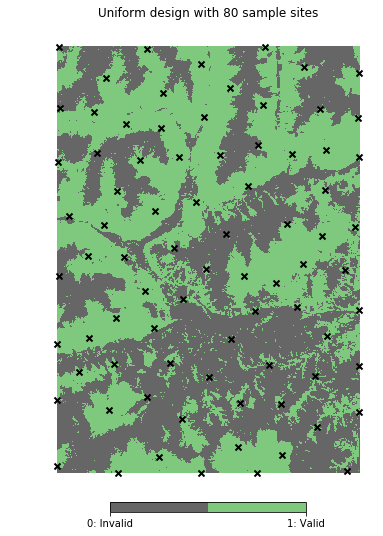

In [155]:
plt.figure(figsize=(7, 9))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('{} design with {} sample sites'.format('Uniform', len(x_unif)))
plt.axis('off')
cbar = plt.colorbar(fraction=0.02, orientation='horizontal', pad=0.01)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.scatter(y_unif, x_unif, c='black', marker='x', linewidth=2)
plt.savefig('{}/{}_{}Site_Uniform_Plot.tif'.format(directory, ts, nsp))
plt.show()

### Save the design

The below function converts the (x, y) coordinates specifying pixels in the image to longitude and latitude coordinates. Geo-information extracted from the input "invalid areas mask" is used to transform the points to long-lat. 

In [24]:
file_raw = gdal.Open(mask_path)

srs = osr.SpatialReference()
srs.ImportFromWkt(file_raw.GetProjection())

0

In [27]:
srsLatLong = srs.CloneGeogCS()

In [29]:
ct = osr.CoordinateTransformation(srs, srsLatLong)

In [30]:
ct

<osgeo.osr.CoordinateTransformation; proxy of <Swig Object of type 'OSRCoordinateTransformationShadow *' at 0x0000021AC6B9B2A0> >

In [35]:
print(ct.TransformPoint(1000, 1000))

(80.88127412159001, -85.53507302812842, 0.0)


In [37]:
indataset = gdal.Open( mask_path, gdal.GA_ReadOnly)
geomatrix = indataset.GetGeoTransform()

In [40]:
pixel_x = 1; pixel_y = 1
line 

X = geomatrix[0] + geomatrix[1] * pixel_x + geomatrix[2] * line
Y = geomatrix[3] + geomatrix[4] * pixel_y + geomatrix[5] * line

# shift to the center of the pixel
X += geomatrix[1] / 2.0
Y += geomatrix[5] / 2.0

# build spatial coordinate system 
srs = osr.SpatialReference()
if srs.ImportFromWkt(indataset.GetPojection()) != 0:
    print("Error: cannot import projection '%s'" % indataset.GetProjection())
    sys.exit(1)
    
srsLatLong = srs.CloneGeogCS()
ct = osr.CoordinateTransformation(srs, srsLatLong)
(int, lat, height) = ct.TransformPoint(X, Y)


NameError: name 'line' is not defined

In [15]:
def LongLatConvert(x, y, GeoT, auth_code):
    x_proj = x * GeoT[1] + GeoT[0] + (GeoT[1] / 2)
    y_proj = y * GeoT[5] + GeoT[3] + (GeoT[5] / 2)
    p1 = pyproj.Proj(init='EPSG:'+auth_code)
    longlat = p1(x_proj, y_proj, inverse=True)
    return longlat

In [16]:
# Convert from row/col to projected
longlat = LongLatConvert(x_strat, y_strat, GeoT, auth_code)

RuntimeError: b'no arguments in initialization list'

Save the coordinates in a csv file...

In [32]:
# Reformat and save to csv
result = pd.DataFrame(list(zip(*longlat)), columns = ['longitude','latitude'])
result.index += 1; result['row'] = x_strat; result['col'] = y_strat
result['sampled'] = np.array([0]*nsp)
csv_filename = '{}_{}Site_Stratified.csv'.format(ts, nsp)
result.to_csv('{}/{}'.format(directory, csv_filename), index_label='site')
print('Design results saved as a csv in {} directory \nFile name: {}'.format(directory, csv_filename))

NameError: name 'longlat' is not defined

### Example output:

Print the first few lines of the csv file...

In [96]:
view_csv = pd.read_csv('{}/{}'.format(directory, csv_filename))

In [97]:
view_csv.head()

,site,longitude,latitude,row,col,sampled
0,1,172.575026,-42.517812,834.0,377.0,0
1,2,172.268461,-42.419761,0.0,0.0,0
2,3,172.336065,-42.615136,174.0,726.0,0
3,4,172.447568,-42.422772,491.0,19.0,0
4,5,172.638446,-42.415069,1015.0,0.0,0


Columns consist of:
* A **site** ID
* The coordinates in **longitude** and **latitude**
* The coordinates in **row** and **column** (corresponding to pixels in image)
* A **sampled** column: This is used when generating an *adapted design*. When conducting the survey sites which have been sampled can be tagged with a 1 in this column. Unsampled sites remain tagged with a 0. **For example see demo_adapted_stratified notebook**. 